In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten,Dense,Activation
from keras import backend as K

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape , Y_train.shape , X_test.shape , Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [5]:
X_train /= 255
X_test  /= 255

In [7]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train, 10)

In [6]:
nh1 = 5
nh2 = 5
ny = 10

batch_size = 64

In [8]:
def test_accuracy(model):
  test_predict  = model.predict(X_test)
  test_res = np.argwhere(test_predict==np.amax(test_predict,1, keepdims=True))
  test_res = test_res[:,1].reshape((test_res.shape[0]))
  acc = 1 - (np.count_nonzero(np.subtract(test_res,Y_test))/test_res.shape[0])
  return acc

In [9]:
def loss_plot(history,label):
  loss = history.history['loss']
  plt.clf()
  x = np.linspace(0,len(loss),len(loss))
  plt.plot(x,loss,'black',label="Loss of "+label)
  plt.legend()

In [10]:
class Custom_Loss_Function(tf.keras.losses.Loss):
    def __init__(self , model , landa):
        super().__init__()
        self.model = model
        self.landa = landa

    def call(self, y_true, y_pred):
        correlation = tf.matmul(y_true,tf.transpose(y_true))
        mul = tf.math.abs(tf.matmul(y_pred,tf.transpose(y_pred)))

        s = tf.reduce_mean(tf.math.multiply(correlation , mul))
        d = tf.reduce_mean(tf.math.multiply(tf.ones_like(correlation)-correlation , mul))

        cost = 1-s+d
        log_y_pred = tf.math.log(y_pred)
        elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        return tf.reduce_mean(tf.reduce_sum(elements,axis=1)) + self.landa * cost

In [11]:
class ModelOutputCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    tf.keras.callbacks.Callback.__init__(self)

  def on_train_batch_end(self, batch, logs=None):
    global batch_num
    batch_num = int(batch)+1
        

In [12]:
class L_new(tf.keras.losses.Loss):
    def __init__(self , model , landa , batch_size):
        super().__init__()
        self.model = model
        self.landa = landa
        self.batch_size = batch_size
        self.layer1_model = tf.keras.Model(inputs=self.model.input,outputs=self.model.layers[1].output)
        self.layer2_model = tf.keras.Model(inputs=self.model.input,outputs=self.model.layers[2].output)
    
    @tf.function
    def call(self, y_true, y_pred):
        global batch_num
        data = X_train[batch_num * self.batch_size : min(X_train.shape[0] , batch_num+1 * self.batch_size) , : , :]
        layer1_output = self.layer1_model(data)
        layer2_output = self.layer2_model(data)
        mul = tf.matmul(layer1_output , tf.transpose(layer2_output))
        cost =  tf.reduce_mean(tf.math.abs(tf.ones_like(mul) - tf.math.abs(mul)))
        log_y_pred = tf.math.log(y_pred)
        elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        cross_entropy = tf.reduce_mean(tf.reduce_sum(elements,axis=1))
        return cross_entropy + self.landa * cost

In [30]:
model1 = Sequential()
model1.add(Flatten(input_shape=(X_train.shape[1] , X_train.shape[2]))) # input layer
model1.add(Dense(nh1 , activation='sigmoid')) # first hidden layer
model1.add(Dense(nh2 , activation='sigmoid')) # second hidden layer
model1.add(Dense(ny , activation='softmax')) # output layer
model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.99, nesterov=True) , 
                loss= tf.keras.losses.CategoricalCrossentropy() , metrics=['accuracy'] )
history1 = model1.fit(X_train , Y_train_oh , epochs = 20 , batch_size = batch_size , verbose = 2)

Epoch 1/20
938/938 - 2s - loss: 1.0637 - accuracy: 0.6502 - 2s/epoch - 2ms/step
Epoch 2/20
938/938 - 1s - loss: 0.8128 - accuracy: 0.7701 - 1s/epoch - 1ms/step
Epoch 3/20
938/938 - 1s - loss: 0.7285 - accuracy: 0.8134 - 1s/epoch - 2ms/step
Epoch 4/20
938/938 - 1s - loss: 0.6749 - accuracy: 0.8298 - 1s/epoch - 2ms/step
Epoch 5/20
938/938 - 2s - loss: 0.6485 - accuracy: 0.8359 - 2s/epoch - 2ms/step
Epoch 6/20
938/938 - 1s - loss: 0.6401 - accuracy: 0.8369 - 1s/epoch - 2ms/step
Epoch 7/20
938/938 - 1s - loss: 0.6197 - accuracy: 0.8420 - 1s/epoch - 2ms/step
Epoch 8/20
938/938 - 1s - loss: 0.6225 - accuracy: 0.8444 - 1s/epoch - 2ms/step
Epoch 9/20
938/938 - 1s - loss: 0.6055 - accuracy: 0.8467 - 1s/epoch - 2ms/step
Epoch 10/20
938/938 - 1s - loss: 0.6065 - accuracy: 0.8493 - 1s/epoch - 2ms/step
Epoch 11/20
938/938 - 1s - loss: 0.6001 - accuracy: 0.8504 - 1s/epoch - 1ms/step
Epoch 12/20
938/938 - 1s - loss: 0.6061 - accuracy: 0.8502 - 1s/epoch - 2ms/step
Epoch 13/20
938/938 - 1s - loss: 0.60

In [31]:
test_accuracy(model1)

313/313 [==============================] - 0s 1ms/step


0.8549

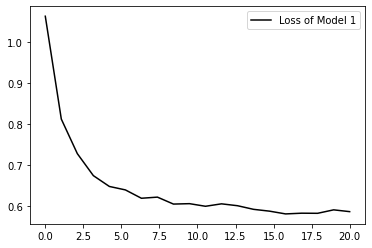

In [32]:
loss_plot(history1,"Model 1")

In [33]:
batch_num = 0
model2 = Sequential()
model2.add(Flatten(input_shape=(X_train.shape[1] , X_train.shape[2]))) # input layer
model2.add(Dense(nh1 , activation='sigmoid')) # first hidden layer
model2.add(Dense(nh2 , activation='sigmoid')) # second hidden layer
model2.add(Dense(ny , activation='softmax')) # output layer
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.99, nesterov=True) , 
                loss= L_new(model2,0.1 , batch_size) , metrics=['accuracy'])
history2 = model2.fit(X_train , Y_train_oh , epochs = 20 , batch_size = batch_size , verbose = 2 , callbacks=[ModelOutputCallback()])

Epoch 1/20
938/938 - 3s - loss: 1.0973 - accuracy: 0.6666 - 3s/epoch - 3ms/step
Epoch 2/20
938/938 - 3s - loss: 0.7847 - accuracy: 0.7679 - 3s/epoch - 3ms/step
Epoch 3/20
938/938 - 2s - loss: 0.7349 - accuracy: 0.7834 - 2s/epoch - 2ms/step
Epoch 4/20
938/938 - 2s - loss: 0.7189 - accuracy: 0.7849 - 2s/epoch - 2ms/step
Epoch 5/20
938/938 - 2s - loss: 0.6922 - accuracy: 0.7910 - 2s/epoch - 2ms/step
Epoch 6/20
938/938 - 2s - loss: 0.6703 - accuracy: 0.8043 - 2s/epoch - 2ms/step
Epoch 7/20
938/938 - 2s - loss: 0.6512 - accuracy: 0.8298 - 2s/epoch - 2ms/step
Epoch 8/20
938/938 - 2s - loss: 0.6150 - accuracy: 0.8496 - 2s/epoch - 2ms/step
Epoch 9/20
938/938 - 2s - loss: 0.6082 - accuracy: 0.8541 - 2s/epoch - 2ms/step
Epoch 10/20
938/938 - 2s - loss: 0.6104 - accuracy: 0.8531 - 2s/epoch - 2ms/step
Epoch 11/20
938/938 - 2s - loss: 0.6114 - accuracy: 0.8555 - 2s/epoch - 2ms/step
Epoch 12/20
938/938 - 2s - loss: 0.6026 - accuracy: 0.8599 - 2s/epoch - 2ms/step
Epoch 13/20
938/938 - 2s - loss: 0.59

In [34]:
test_accuracy(model2)

313/313 [==============================] - 0s 1ms/step


0.866

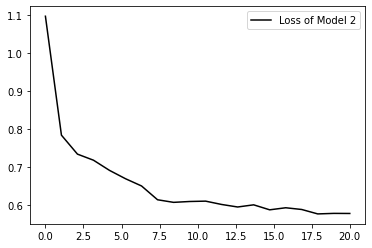

In [35]:
loss_plot(history2,"Model 2")

In [36]:
batch_num = 0
model3 = Sequential()
model3.add(Flatten(input_shape=(X_train.shape[1] , X_train.shape[2]))) # input layer
model3.add(Dense(nh1 , activation='sigmoid')) # first hidden layer
model3.add(Dense(nh2 , activation='sigmoid')) # second hidden layer
model3.add(Dense(ny , activation='softmax')) # output layer
model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.99, nesterov=True) ,
                loss= L_new(model3,0.001,batch_size) , metrics=['accuracy'] )
history3 = model3.fit(X_train , Y_train_oh , epochs = 20 , batch_size = batch_size , verbose = 2)

Epoch 1/20
938/938 - 2s - loss: 1.0588 - accuracy: 0.6792 - 2s/epoch - 3ms/step
Epoch 2/20
938/938 - 2s - loss: 0.7658 - accuracy: 0.8038 - 2s/epoch - 2ms/step
Epoch 3/20
938/938 - 2s - loss: 0.7187 - accuracy: 0.8120 - 2s/epoch - 2ms/step
Epoch 4/20
938/938 - 2s - loss: 0.6719 - accuracy: 0.8245 - 2s/epoch - 2ms/step
Epoch 5/20
938/938 - 2s - loss: 0.6442 - accuracy: 0.8352 - 2s/epoch - 2ms/step
Epoch 6/20
938/938 - 2s - loss: 0.6443 - accuracy: 0.8380 - 2s/epoch - 2ms/step
Epoch 7/20
938/938 - 2s - loss: 0.6428 - accuracy: 0.8353 - 2s/epoch - 2ms/step
Epoch 8/20
938/938 - 2s - loss: 0.6216 - accuracy: 0.8452 - 2s/epoch - 2ms/step
Epoch 9/20
938/938 - 2s - loss: 0.6265 - accuracy: 0.8433 - 2s/epoch - 2ms/step
Epoch 10/20
938/938 - 2s - loss: 0.6111 - accuracy: 0.8522 - 2s/epoch - 2ms/step
Epoch 11/20
938/938 - 2s - loss: 0.6075 - accuracy: 0.8518 - 2s/epoch - 2ms/step
Epoch 12/20
938/938 - 2s - loss: 0.6147 - accuracy: 0.8493 - 2s/epoch - 2ms/step
Epoch 13/20
938/938 - 2s - loss: 0.59

In [37]:
test_accuracy(model3)

313/313 [==============================] - 0s 1ms/step


0.8582

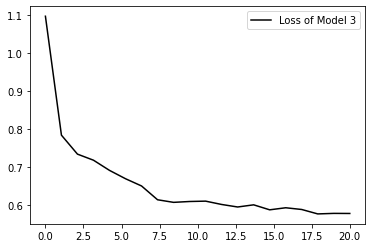

In [38]:
loss_plot(history2,"Model 3")

In [58]:
batch_num = 0
model4 = Sequential()
model4.add(Flatten(input_shape=(X_train.shape[1] , X_train.shape[2]))) # input layer
model4.add(Dense(nh1 , activation='sigmoid')) # first hidden layer
model4.add(Dense(nh2 , activation='sigmoid')) # second hidden layer
model4.add(Dense(ny , activation='softmax')) # output layer
model4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.99, nesterov=True) , 
                loss= L_new(model4,0.00001,batch_size) , metrics=['accuracy'])
history4 = model4.fit(X_train , Y_train_oh , epochs = 20 , batch_size = batch_size , verbose = 2)

Epoch 1/20
938/938 - 2s - loss: 1.0363 - accuracy: 0.6536 - 2s/epoch - 2ms/step
Epoch 2/20
938/938 - 2s - loss: 0.7138 - accuracy: 0.7692 - 2s/epoch - 2ms/step
Epoch 3/20
938/938 - 2s - loss: 0.6788 - accuracy: 0.7843 - 2s/epoch - 2ms/step
Epoch 4/20
938/938 - 2s - loss: 0.6757 - accuracy: 0.7871 - 2s/epoch - 2ms/step
Epoch 5/20
938/938 - 2s - loss: 0.6474 - accuracy: 0.7931 - 2s/epoch - 2ms/step
Epoch 6/20
938/938 - 2s - loss: 0.6145 - accuracy: 0.8276 - 2s/epoch - 2ms/step
Epoch 7/20
938/938 - 2s - loss: 0.5931 - accuracy: 0.8454 - 2s/epoch - 2ms/step
Epoch 8/20
938/938 - 2s - loss: 0.5928 - accuracy: 0.8438 - 2s/epoch - 2ms/step
Epoch 9/20
938/938 - 2s - loss: 0.5742 - accuracy: 0.8525 - 2s/epoch - 2ms/step
Epoch 10/20
938/938 - 2s - loss: 0.5750 - accuracy: 0.8541 - 2s/epoch - 2ms/step
Epoch 11/20
938/938 - 2s - loss: 0.5789 - accuracy: 0.8510 - 2s/epoch - 2ms/step
Epoch 12/20
938/938 - 2s - loss: 0.5582 - accuracy: 0.8617 - 2s/epoch - 2ms/step
Epoch 13/20
938/938 - 2s - loss: 0.56

In [61]:
test_accuracy(model4)

313/313 [==============================] - 0s 1ms/step


0.866

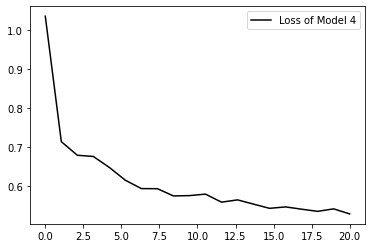

In [62]:
loss_plot(history4,"Model 4")

In [63]:
batch_num = 0
model5 = Sequential()
model5.add(Flatten(input_shape=(X_train.shape[1] , X_train.shape[2]))) # input layer
model5.add(Dense(nh1 , activation='sigmoid')) # first hidden layer
model5.add(Dense(nh2 , activation='sigmoid')) # second hidden layer
model5.add(Dense(ny , activation='softmax')) # output layer
model5.compile(optimizer='adam' , loss= L_new(model5,0.00001 , batch_size) , metrics=['accuracy'] )
history5 = model5.fit(X_train , Y_train_oh , epochs = 20 , batch_size = batch_size , verbose = 2)

Epoch 1/20
938/938 - 3s - loss: 2.0376 - accuracy: 0.4105 - 3s/epoch - 4ms/step
Epoch 2/20
938/938 - 2s - loss: 1.4308 - accuracy: 0.6717 - 2s/epoch - 2ms/step
Epoch 3/20
938/938 - 2s - loss: 1.0450 - accuracy: 0.7521 - 2s/epoch - 2ms/step
Epoch 4/20
938/938 - 2s - loss: 0.8429 - accuracy: 0.7864 - 2s/epoch - 2ms/step
Epoch 5/20
938/938 - 2s - loss: 0.7267 - accuracy: 0.8134 - 2s/epoch - 2ms/step
Epoch 6/20
938/938 - 2s - loss: 0.6526 - accuracy: 0.8328 - 2s/epoch - 2ms/step
Epoch 7/20
938/938 - 2s - loss: 0.6022 - accuracy: 0.8426 - 2s/epoch - 2ms/step
Epoch 8/20
938/938 - 2s - loss: 0.5679 - accuracy: 0.8491 - 2s/epoch - 2ms/step
Epoch 9/20
938/938 - 3s - loss: 0.5440 - accuracy: 0.8525 - 3s/epoch - 3ms/step
Epoch 10/20
938/938 - 2s - loss: 0.5258 - accuracy: 0.8568 - 2s/epoch - 2ms/step
Epoch 11/20
938/938 - 2s - loss: 0.5123 - accuracy: 0.8594 - 2s/epoch - 2ms/step
Epoch 12/20
938/938 - 2s - loss: 0.4998 - accuracy: 0.8632 - 2s/epoch - 2ms/step
Epoch 13/20
938/938 - 2s - loss: 0.48

In [66]:
test_accuracy(model5)

313/313 [==============================] - 0s 1ms/step


0.8717

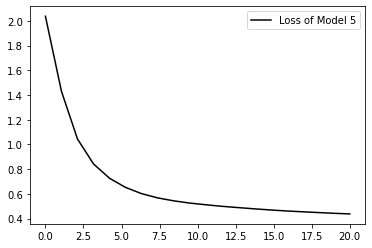

In [65]:
loss_plot(history5,"Model 5")

In [73]:
model6 = Sequential()
model6.add(Flatten(input_shape=(X_train.shape[1] , X_train.shape[2]))) # input layer
model6.add(Dense(nh1 , activation='sigmoid')) # first hidden layer
model6.add(Dense(nh2 , activation='sigmoid')) # second hidden layer
model6.add(Dense(ny , activation='softmax')) # output layer
model6.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.99, nesterov=True) ,
                loss= Custom_Loss_Function(model6,0.1) , metrics=['accuracy'] )
history6 = model6.fit(X_train , Y_train_oh , epochs = 20 , batch_size = batch_size , verbose = 2)

Epoch 1/20
938/938 - 2s - loss: 1.1190 - accuracy: 0.6884 - 2s/epoch - 2ms/step
Epoch 2/20
938/938 - 2s - loss: 0.8605 - accuracy: 0.7980 - 2s/epoch - 2ms/step
Epoch 3/20
938/938 - 2s - loss: 0.8025 - accuracy: 0.8152 - 2s/epoch - 2ms/step
Epoch 4/20
938/938 - 2s - loss: 0.7778 - accuracy: 0.8228 - 2s/epoch - 2ms/step
Epoch 5/20
938/938 - 2s - loss: 0.7498 - accuracy: 0.8347 - 2s/epoch - 2ms/step
Epoch 6/20
938/938 - 2s - loss: 0.7536 - accuracy: 0.8324 - 2s/epoch - 2ms/step
Epoch 7/20
938/938 - 2s - loss: 0.7366 - accuracy: 0.8388 - 2s/epoch - 2ms/step
Epoch 8/20
938/938 - 2s - loss: 0.7491 - accuracy: 0.8354 - 2s/epoch - 2ms/step
Epoch 9/20
938/938 - 2s - loss: 0.7261 - accuracy: 0.8445 - 2s/epoch - 2ms/step
Epoch 10/20
938/938 - 2s - loss: 0.7087 - accuracy: 0.8496 - 2s/epoch - 2ms/step
Epoch 11/20
938/938 - 2s - loss: 0.7155 - accuracy: 0.8474 - 2s/epoch - 2ms/step
Epoch 12/20
938/938 - 2s - loss: 0.7151 - accuracy: 0.8465 - 2s/epoch - 2ms/step
Epoch 13/20
938/938 - 2s - loss: 0.69

In [74]:
test_accuracy(model6)

313/313 [==============================] - 0s 1ms/step


0.8573

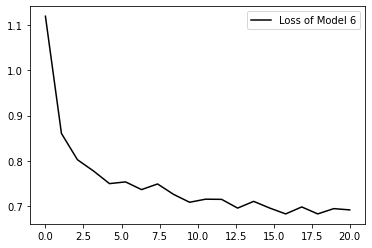

In [75]:
loss_plot(history6,"Model 6")

In [72]:
model7 = Sequential()
model7.add(Flatten(input_shape=(X_train.shape[1] , X_train.shape[2]))) # input layer
model7.add(Dense(nh1 , activation='sigmoid')) # first hidden layer
model7.add(Dense(nh2 , activation='sigmoid')) # second hidden layer
model7.add(Dense(ny , activation='softmax')) # output layer
model7.compile(optimizer='adam' , loss= Custom_Loss_Function(model7,0.1) , metrics=['accuracy'] )
history7 = model7.fit(X_train , Y_train_oh , epochs = 20 , batch_size = batch_size , verbose = 2)

Epoch 1/20
938/938 - 2s - loss: 2.1585 - accuracy: 0.3446 - 2s/epoch - 3ms/step
Epoch 2/20
938/938 - 2s - loss: 1.6125 - accuracy: 0.5585 - 2s/epoch - 2ms/step
Epoch 3/20
938/938 - 2s - loss: 1.2765 - accuracy: 0.7053 - 2s/epoch - 2ms/step
Epoch 4/20
938/938 - 2s - loss: 1.0555 - accuracy: 0.7764 - 2s/epoch - 2ms/step
Epoch 5/20
938/938 - 2s - loss: 0.8970 - accuracy: 0.8274 - 2s/epoch - 2ms/step
Epoch 6/20
938/938 - 2s - loss: 0.7829 - accuracy: 0.8488 - 2s/epoch - 2ms/step
Epoch 7/20
938/938 - 2s - loss: 0.7051 - accuracy: 0.8594 - 2s/epoch - 2ms/step
Epoch 8/20
938/938 - 2s - loss: 0.6554 - accuracy: 0.8645 - 2s/epoch - 2ms/step
Epoch 9/20
938/938 - 2s - loss: 0.6244 - accuracy: 0.8671 - 2s/epoch - 2ms/step
Epoch 10/20
938/938 - 2s - loss: 0.6042 - accuracy: 0.8694 - 2s/epoch - 2ms/step
Epoch 11/20
938/938 - 2s - loss: 0.5907 - accuracy: 0.8707 - 2s/epoch - 2ms/step
Epoch 12/20
938/938 - 2s - loss: 0.5807 - accuracy: 0.8724 - 2s/epoch - 2ms/step
Epoch 13/20
938/938 - 2s - loss: 0.57

In [76]:
test_accuracy(model7)

313/313 [==============================] - 0s 1ms/step


0.8757

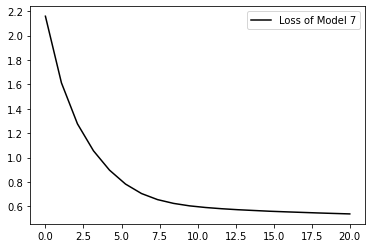

In [77]:
loss_plot(history7,"Model 7")